In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import sklearn.model_selection
import random
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#https://arxiv.org/abs/1903.08289

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preprocessing

In [3]:
df = pd.read_csv('/content/drive/My Drive/STA_561_Final_Project/train.csv')

In [4]:
import re
import string
string.punctuation

def replace_links(text):
  url_regex = "https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,}"
  return re.sub(url_regex, '[URLLINK]', text)

In [5]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
  sentence=str(sentence)
  sentence = sentence.lower()
  sentence=sentence.replace('{html}',"") 
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', sentence)
  rem_url=re.sub(r'http\S+', '',cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)  
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  res = [idx for idx in filtered_words if not re.findall("[^\u0000-\u05C0\u2100-\u214F]+", idx)]
  return " ".join(res)

df['Tweet'] = df['Tweet'].map(lambda s:preprocess(s)) 
df['Tweet'] = df['Tweet'].apply(lambda x: replace_links(x))
df['Tweet'] = df['Tweet'].str.replace('[^\w\s]','')
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z ]', '')
df['Tweet'] = df['Tweet'].str.replace('_',' ')
print(df['Tweet'])

df['is_spam'] = df['Type'].map({"Quality": 0, "Spam":1})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
0        everything else complicated pesummit pxpic twi...
1        eren sent glare towards mikasa nodded stood he...
2                                posted new photo facebook
3        jan idiot chelsea handler diagnoses trump disease
4        pedophile anthony weiner terrified getting bea...
                               ...                        
11963                                           meet harry
11964      bbc food disappears loss knowledge catastrophic
11965              look liberals historic monument arizona
11966    uploaded new track everyday lite spreaker lite...
11967    trump declared victor tonight based exit poll ...
Name: Tweet, Length: 11968, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: The default value of regex will change from True to False in a future version.


### RNN Classifier

In [ ]:
example = df['Tweet']
label = df['is_spam']

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(example, label, test_size=0.2,random_state=42)
print(X_train); print(y_train);

BUFFER_SIZE = 1000
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_train), tf.data.Dataset.from_tensor_slices(y_train)))
test_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_test), tf.data.Dataset.from_tensor_slices(y_test)))

for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

11359    THIS WAS SO FUCKING FUNNY I PEED MY PANTS FOR ...
9825     Push Power Hits - Hit songs in all genres -&gt...
3349     Breakfast lunch and dinner \n#goodfoodrealfood...
10765    GERMANY and AMSTERDAM! The hills are alive!!![...
11578    Is it me or selling drugs on Facebook a easy c...
                               ...                        
11284    500 pound bomb dropped on U.S. Soldiers by mis...
5191     First Tennessee Park to host Kings of Leon for...
5390     Returning home is a mixed blessing for victims...
860      End House is under attack.\nNature has its fin...
7270     Consumer Reports finds best ellipticals, tread...
Name: Tweet, Length: 9574, dtype: object
11359    0
9825     1
3349     0
10765    0
11578    1
        ..
11284    1
5191     1
5390     1
860      0
7270     1
Name: is_spam, Length: 9574, dtype: int64
text:  b'THIS WAS SO FUCKING FUNNY I PEED MY PANTS FOR AN HOUR[URLLINK]\xc2\xa0\xe2\x80\xa6'
label:  0


array(['', '[UNK]', 'urllink', 'the', 'to', 'in', 'a', 'of', 'for', 'and',
       'you', 'i', 'is', 'on', 'this', 'with', 'it', 'at', 'that', 'be'],
      dtype='<U16')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

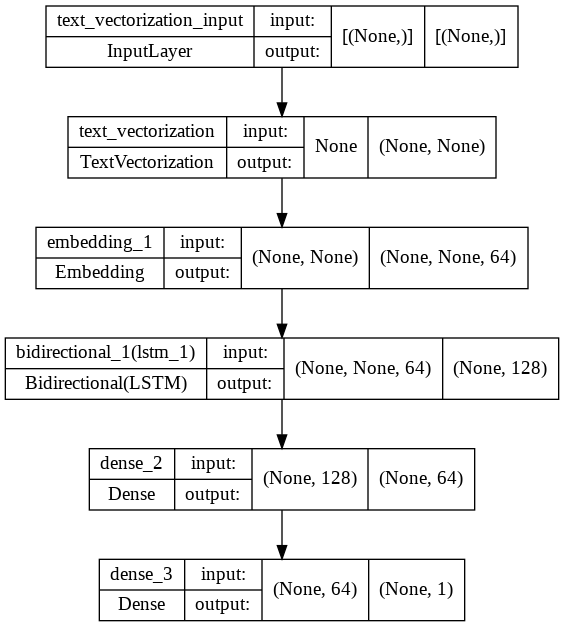

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
150/150 [==============================] - 21s 84ms/step - loss: 0.6699 - accuracy: 0.5175 - val_loss: 0.6228 - val_accuracy: 0.5151
Epoch 2/10
150/150 [==============================] - 10s 66ms/step - loss: 0.4747 - accuracy: 0.7539 - val_loss: 0.3957 - val_accuracy: 0.8396
Epoch 3/10
150/150 [==============================] - 10s 66ms/step - loss: 0.3492 - accuracy: 0.8502 - val_loss: 0.3597 - val_accuracy: 0.8620
Epoch 4/10
150/150 [==============================] - 9s 62ms/step - loss: 0.3107 - accuracy: 0.8716 - val_loss: 0.3392 - val_accuracy: 0.8635
Epoch 5/10
150/150 [==============================] - 10s 64ms/step - loss: 0.2872 - accuracy: 0.8806 - val_loss: 0.3459 - val_accuracy: 0.8687
Epoch 6/10
150/150 [==============================] - 10s 70ms/step - loss: 0.2683 - accuracy: 0.8904 - val_loss: 0.3263 - val_accuracy: 0.8698
Epoch 7/10
150/150 [==============================] - 9s 63ms/step - loss: 0.2585 - accuracy: 0.8947 - val_loss: 0.3265 - val_accuracy: 0

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

38/38 [==============================] - 1s 17ms/step - loss: 0.3282 - accuracy: 0.8697
Test Loss: 0.32819220423698425
Test Accuracy: 0.8696742057800293


### RNN Classifier (Input From Parallel Generative Network)

This scheme is referred to in the report as the **Generative RNN**

In [6]:
df_not_spam = pd.read_csv('/content/drive/My Drive/STA_561_Final_Project/not_spam.csv') # This file is outputted by STA_561_Generator_Not_Spam.csv
df_spam = pd.read_csv('/content/drive/My Drive/STA_561_Final_Project/spam.csv') # This file is outputted by STA_561_Generator_Spam.csv

print(df_not_spam)
print(df_spam)

      Unnamed: 0                                              Tweet
0              0  kindly explain vorxogzxyghbkzfrkqkpreeeverfeve...
1              1  good point                                    ...
2              2  got mins xkookqkrdxfjhkjphlstereqyknrfhwssvsyc...
3              3  scientifical mystical                         ...
4              4  marcosadiehl scope win mamily                 ...
...          ...                                                ...
1245        1245  foxhillmanor pampering vator comdbyuii        ...
1246        1246  must careful odeknxveecceeeehzocvzakcfhqbveevh...
1247        1247  brandstorytellers afraid seel                 ...
1248        1248  twitter adtech                                ...
1249        1249  second dublin                                 ...

[1250 rows x 2 columns]
      Unnamed: 0                                              Tweet
0              0                meet refince deputies switcher d...
1              1       

In [7]:
example = df['Tweet']
label = df['is_spam']

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(example, label, test_size=0.2,random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train); print(y_train);

# Append generated spam and not-spam data to original dataset
X_train = np.append(X_train, np.array(df_not_spam['Tweet']))
y_train = np.append(y_train, np.array([0] * 1250))
X_train = np.append(X_train, np.array(df_spam['Tweet']))
y_train = np.append(y_train, np.array([1] * 1250))

BUFFER_SIZE = 1000
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_train), tf.data.Dataset.from_tensor_slices(y_train)))
test_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_test), tf.data.Dataset.from_tensor_slices(y_test)))

for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

['fucking funny peed pants hour' 'push power hits hit songs genres'
 'breakfast lunch dinner goodfoodrealfood justlovenibbles justlovehub supersalad pizza'
 ... 'returning home mixed blessing victims boko haram politics'
 'end house attack nature final say dead game bookspecials horrorpic twitter com drdzhmdinn'
 'consumer reports finds best ellipticals treadmills work home']
[0 1 0 ... 1 0 1]
text:  b'fucking funny peed pants hour'
label:  0


array(['', '[UNK]', 'twitter', 'com', 'pic', 'news', 'trump', 'new',
       'like', 'get', 'one', 'people', 'day', 'police', 'man', 'world',
       'breaking', 'love', 'via', 'know'], dtype='<U17')

In [8]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [9]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [10]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
189/189 [==============================] - 22s 55ms/step - loss: 0.6751 - accuracy: 0.5156 - val_loss: 0.6563 - val_accuracy: 0.5339
Epoch 2/10
189/189 [==============================] - 7s 37ms/step - loss: 0.5247 - accuracy: 0.6999 - val_loss: 0.7300 - val_accuracy: 0.7422
Epoch 3/10
189/189 [==============================] - 7s 37ms/step - loss: 0.4074 - accuracy: 0.8222 - val_loss: 0.6829 - val_accuracy: 0.7547
Epoch 4/10
189/189 [==============================] - 8s 44ms/step - loss: 0.3784 - accuracy: 0.8400 - val_loss: 0.5813 - val_accuracy: 0.7771
Epoch 5/10
189/189 [==============================] - 7s 37ms/step - loss: 0.3535 - accuracy: 0.8491 - val_loss: 0.5760 - val_accuracy: 0.7797
Epoch 6/10
189/189 [==============================] - 7s 36ms/step - loss: 0.3409 - accuracy: 0.8551 - val_loss: 0.5695 - val_accuracy: 0.7786
Epoch 7/10
189/189 [==============================] - 7s 37ms/step - loss: 0.3313 - accuracy: 0.8592 - val_loss: 0.5761 - val_accuracy: 0.778

In [11]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

38/38 [==============================] - 0s 11ms/step - loss: 0.5509 - accuracy: 0.7874
Test Loss: 0.5509452819824219
Test Accuracy: 0.787385106086731


### Tokenize Tweets w/ Padding + Max Len 50 (For SVM and Logistic Regression)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [ ]:
max_len = 50 #approximately the 280 character tweet limit => 50
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
vocab_size = 500

tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(df.Tweet)

In [ ]:
training_sequences = tokenizer.texts_to_sequences(df.Tweet)
X1 = pad_sequences(training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)
y = df.is_spam

In [ ]:
xi=tokenizer.word_index
print(xi)
emb_index = xi.items()
print(emb_index)

{'<OOV>': 1, 'urllink': 2, 'the': 3, 'to': 4, 'in': 5, 'a': 6, 'of': 7, 'twitter': 8, 'com': 9, 'for': 10, 'and': 11, 'i': 12, 'you': 13, 'is': 14, 'on': 15, '\xa0…': 16, 'this': 17, 'with': 18, 'it': 19, 'at': 20, 'that': 21, 'be': 22, 'my': 23, 'news': 24, 'pic': 25, 'are': 26, 'trump': 27, 'your': 28, 'not': 29, 'me': 30, 'from': 31, 'by': 32, 'have': 33, 'we': 34, 'so': 35, 'just': 36, 'new': 37, 'out': 38, 'all': 39, 'as': 40, '\xa0': 41, 'will': 42, 'rt': 43, 'was': 44, 'up': 45, 'if': 46, 'what': 47, 'like': 48, 'when': 49, 'but': 50, 'about': 51, 'do': 52, 'no': 53, 'how': 54, 'get': 55, 'can': 56, 'who': 57, "i'm": 58, 'they': 59, 'now': 60, 'after': 61, 'more': 62, 'has': 63, '\xa0pic': 64, 'one': 65, "'": 66, 'our': 67, 'he': 68, 'people': 69, "don't": 70, 'u': 71, 'day': 72, 'his': 73, 'via': 74, 'love': 75, 'an': 76, 'police': 77, 'her': 78, 'over': 79, "it's": 80, 'man': 81, 'why': 82, 'know': 83, '2': 84, 'us': 85, 'world': 86, 'or': 87, '1': 88, 'their': 89, 'time': 90,

In [ ]:
print(np.shape(np.array(X1)))
print(np.array(X1[0]))

(11968, 50)
[ 80   3 370   1 189   1   1   1   8   9   1   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


### SVM

In [ ]:
!pip install -U libsvm-official

  Created wheel for libsvm-official: filename=libsvm_official-3.25.0-cp37-cp37m-linux_x86_64.whl size=99091 sha256=064c793f7780464ed0669cb7e9a7e77c255e9210ac131d9398d401692041b468
  Stored in directory: /root/.cache/pip/wheels/c2/c8/dc/2dea0257b8e7196981e07a44abd9b33b0c38abb1a141b6a4f8
Successfully built libsvm-official


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import libsvm
from libsvm.svmutil import *

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.20, random_state=42)
y_train = np.array(y_train); y_test = np.array(y_test);
dataset_train = tf.data.Dataset.from_tensor_slices(X_train)

print('X_train:')
for input_example in dataset_train.take(5):
    print(repr(''.join(tokenizer.sequences_to_texts(np.expand_dims(input_example.numpy(), axis=0)))))

X_train:
'this was so <OOV> <OOV> i <OOV> my <OOV> for an <OOV> urllink \xa0… <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>'
'<OOV> power <OOV> hit <OOV> in all <OOV> gt urllink <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>'
'<OOV> <OOV> and <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> urllink <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>'
'<OOV> and <OOV> the <OOV> are <OOV> urllink \xa0… <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV

In [ ]:
sigma_sq_range = np.arange(10,24,2)

K = 10 # 10-fold cross validation
kf = KFold(n_splits=K, random_state=None, shuffle=False)
train_accuracies = []
test_accuracies = []
num_SVs = np.zeros(len(sigma_sq_range))

for j, sigma_sq in enumerate(sigma_sq_range):
    print("Elapsed time: {}/{}".format(j, len(sigma_sq_range)))
    train_scores = np.zeros(K); test_scores = np.zeros(K); i = 0;

    # Splitting Training Data into 9 training folds and one test fold
    for train_index, test_index in kf.split(X_train):
        X_train_val, X_test_val = X_train[train_index], X_train[test_index]
        y_train_val, y_test_val = y_train[train_index], y_train[test_index]

        # Define the SVM problem
        problem = svm_problem(np.squeeze(y_train_val), X_train_val)
        # Define the hyperparameters
        # Note: gamma = 1/sigma^2
        param = svm_parameter()
        param.kernel_type = RBF
        param.gamma = 1/sigma_sq

        # Train the model
        model = svm_train(problem, param)
        support_vectors = X_train[np.array(model.get_sv_indices()) - 1]
        w = np.matmul(support_vectors.T, model.get_sv_coef())
        b = -model.rho.contents.value
        if model.get_labels()[1] == -1: w = -w; b = -b;
        slope = -w[0]/w[1]
        intercept = b
        
        # Make Predictions on the test fold and save accuracy
        # train_labels, train_acc, train_vals = svm_predict(np.squeeze(y_train_val), X_train_val, model,'-q')
        test_labels, test_acc, test_vals = svm_predict(np.squeeze(y_test_val), X_test_val, model,'-q')
        test_scores[i] = test_acc[0]
        num_SVs[j] = num_SVs[j] + len(support_vectors)
        i = i + 1

    # Average classification accuracy over folds
    # train_accuracies.append(train_scores.mean())
    test_accuracies.append(test_scores.mean())
    num_SVs[j] = num_SVs[j]/K

Elapsed time: 0/7
Elapsed time: 1/7
Elapsed time: 2/7
Elapsed time: 3/7
Elapsed time: 4/7
Elapsed time: 5/7
Elapsed time: 6/7


Validation Accuracies:
[54.72087879006027, 54.80446244898049, 54.85669814551824, 54.84624882472409, 54.86713655887941, 55.013383420265576, 55.03428206185388] 



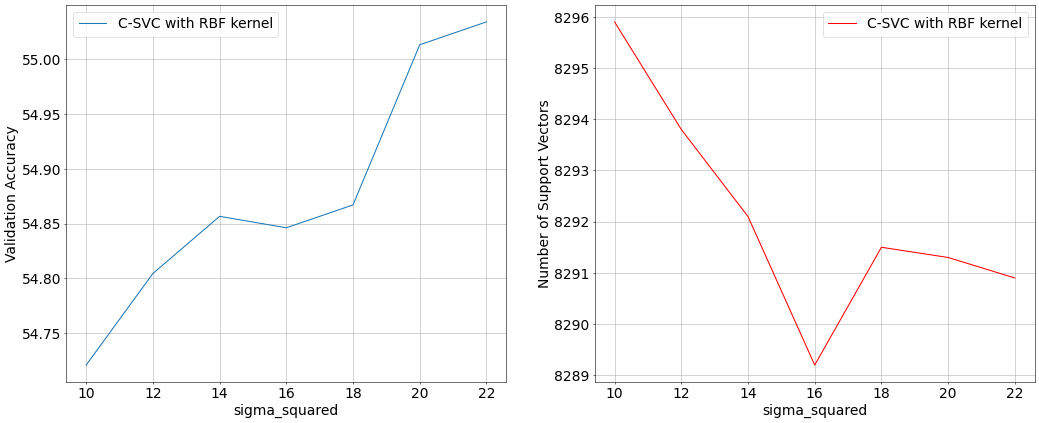

In [ ]:
# print('Train Accuracies:')
# print(train_accuracies)
print('Validation Accuracies:')
print(test_accuracies,'\n')

# Plotting hyperparameters vs validation accuracy (recorded)
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(nrows=1, ncols=2); fig.set_size_inches(25, 10); fig.set_dpi(50);
plt.subplot(1,2,1); plt.plot(sigma_sq_range, test_accuracies); plt.grid();
plt.legend(['C-SVC with RBF kernel'])
plt.xlabel('sigma_squared'); plt.ylabel('Validation Accuracy');
plt.subplot(1,2,2); plt.plot(sigma_sq_range, num_SVs,color='r'); plt.grid();
plt.legend(['C-SVC with RBF kernel'])
plt.xlabel('sigma_squared'); plt.ylabel('Number of Support Vectors');

In [ ]:
# Define the SVM problem
problem = svm_problem(np.squeeze(y_train), X_train)

# Define the hyperparameters
# Note: gamma = 1/sigma^2
param = svm_parameter()
param.kernel_type = RBF
sigma_sq = sigma_sq_range[np.argmax(test_accuracies)]
print(sigma_sq)
param.gamma = 1/sigma_sq

# Train the model (fit optimal parameters to SVM model)
model = svm_train(problem, param)
support_vectors = X_train[np.array(model.get_sv_indices()) - 1]
w = np.matmul(support_vectors.T, model.get_sv_coef())
b = -model.rho.contents.value
if model.get_labels()[1] == -1: w = -w; b = -b;
slope = -w[0]/w[1]
intercept = b

# Obtain predictions on the test set
y_test_pred,_,_ = svm_predict(np.squeeze(y_test), X_test, model,'-q')
print('SVM Accuracy: ', accuracy_score(y_test, y_test_pred))

22
SVM Accuracy:  0.5367585630743525


### Logistic Regression

In [ ]:
def train_classifier(clf, X_train, y_train):    
    clf.fit(X_train, y_train)

def predict_labels(clf, features):
    return(clf.predict(features))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.20, random_state=42)
y_train = np.array(y_train); y_test = np.array(y_test);

In [ ]:
from itertools import product

# Obtaining all possible parameter combinations
parameters = {'penalty': ['l2'],'tol': [1e-3, 1e-4, 1e-5, 1e-6], 'C': [10**-4, 10**-3, 10**-2, 0.1, 1, 10, 100, 1000]}
parameters = [dict(zip(parameters, v)) for v in product(*parameters.values())]

K = 10 # 10-fold cross validation
kf = KFold(n_splits=K, random_state=None, shuffle=False)
eval_params = []

for value, p in enumerate(parameters):
    scores = np.zeros(K)
    i = 0
    if value % 5 == 0: print("Elapsed time: {}/{}".format(value, len(parameters)))

    # Splitting Training Data into 9 training folds and one test fold
    for train_index, test_index in kf.split(X_train):
        X_train_val, X_test_val = X_train[train_index], X_train[test_index]
        y_train_val, y_test_val = y_train[train_index], y_train[test_index]
        clf = LogisticRegression(penalty = p['penalty'], tol = p['tol'], C = p['C'], max_iter = 2000)

        # Obtain classification accuracy
        clf = clf.fit(X_train_val, y_train_val)
        y_pred = clf.predict(X_test_val)
        scores[i] = accuracy_score(y_test_val, y_pred)
        i = i + 1

    # Average classification accuracy over folds
    eval_params.append((p['penalty'], p['tol'], p['C'], scores.mean()))

Elapsed time: 0/32
Elapsed time: 5/32
Elapsed time: 10/32
Elapsed time: 15/32
Elapsed time: 20/32
Elapsed time: 25/32
Elapsed time: 30/32


Optimally Tuned Parameters: [penalty, tol, C] =  ['l2' '0.001' '0.01']
Optimal Validation Accuracy: =  0.5605837003684531 

Accuracies for all Parameter Combinations:
[['l2' '0.001' '0.0001' '0.5595390955120276']
 ['l2' '0.001' '0.001' '0.5602702207446286']
 ['l2' '0.001' '0.01' '0.5605837003684531']
 ['l2' '0.001' '0.1' '0.5602706570419478']
 ['l2' '0.001' '1' '0.5596440250172883']
 ['l2' '0.001' '10' '0.5596440250172883']
 ['l2' '0.001' '100' '0.559539422735017']
 ['l2' '0.001' '1000' '0.5597485182252298']
 ['l2' '0.0001' '0.0001' '0.5595390955120276']
 ['l2' '0.0001' '0.001' '0.5602702207446286']
 ['l2' '0.0001' '0.01' '0.5605837003684531']
 ['l2' '0.0001' '0.1' '0.5602706570419478']
 ['l2' '0.0001' '1' '0.5596440250172883']
 ['l2' '0.0001' '10' '0.5596440250172883']
 ['l2' '0.0001' '100' '0.559539422735017']
 ['l2' '0.0001' '1000' '0.5597485182252298']
 ['l2' '1e-05' '0.0001' '0.5595390955120276']
 ['l2' '1e-05' '0.001' '0.5602702207446286']
 ['l2' '1e-05' '0.01' '0.560583700368453

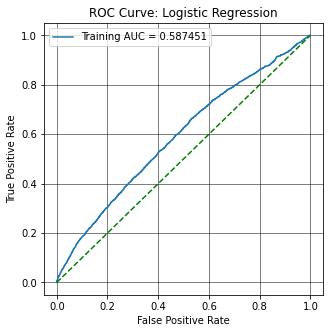

In [ ]:
eval_params = np.array(eval_params)
p_opt = eval_params[np.argmax(eval_params[:,len(eval_params[0])-1])]
print('Optimally Tuned Parameters: [penalty, tol, C] = ', p_opt[0:len(eval_params[0])-1])
print('Optimal Validation Accuracy: = ',p_opt[len(eval_params[0])-1],'\n')
print('Accuracies for all Parameter Combinations:')
print(eval_params,'\n')

# Plotting ROC curve for training data set
clf = LogisticRegression(penalty = p_opt[0], tol = float(p_opt[1]), C = float(p_opt[2]), max_iter = 2000)
clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict_proba(X_train)
train_fpr,train_tpr,_ = roc_curve(y_train, y_train_pred[:,1])
plt.rcParams.update({'font.size': 10}); plt.figure(figsize=(5,5));
plt.plot(train_fpr, train_tpr, label= "Training AUC = %f" %auc(train_fpr, train_tpr))
plt.plot([0,1],[0,1],'g--')
plt.legend(); plt.grid();
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Logistic Regression")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [ ]:
# Fit optimal hyperparameters to logistic regression model
clf = LogisticRegression(penalty = p_opt[0], tol = float(p_opt[1]), C = float(p_opt[2]), max_iter = 2000)

# Obtain predictions on the test set
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Logistic Regression Accuracy: ', accuracy_score(y_test, y_pred))

Logistic Regression Accuracy:  0.5609857978279031


### Word-based Generator (Deprecated)

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text


# print(tokenizer.sequences_to_texts(X1))
dataset = tf.data.Dataset.from_tensor_slices(X1)

dataset_not = tf.data.Dataset.from_tensor_slices(X1[df['is_spam'].isin([0])])
dataset_spam = tf.data.Dataset.from_tensor_slices(X1[df['is_spam'].isin([1])])

dataset_not = dataset_not.map(split_input_target)
dataset_spam = dataset_spam.map(split_input_target)

print('No spam dataset size: {}'.format(len(list(dataset_not.as_numpy_iterator()))))
print('Spam dataset size: {}'.format(len(list(dataset_spam.as_numpy_iterator()))))

for input_example, target_example in dataset_not.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(tokenizer.sequences_to_texts(np.expand_dims(input_example.numpy(), axis=0)))))
    print('Target:', repr(''.join(tokenizer.sequences_to_texts(np.expand_dims(target_example.numpy(), axis=0)))))


No spam dataset size: 6153
Spam dataset size: 5815
Input sequence size: 29
Target sequence size: 29

Input: "it's the everything <OOV> that's <OOV> <OOV> <OOV> twitter com <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>"
Target: "the everything <OOV> that's <OOV> <OOV> <OOV> twitter com <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>"


In [ ]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

batch_not = dataset_not.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
batch_spam = dataset_spam.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

print('Batched no spam dataset size: {}'.format(len(list(batch_not.as_numpy_iterator()))))
print('Batched spam dataset size: {}'.format(len(list(batch_spam.as_numpy_iterator()))))

for input_text, target_text in batch_not.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

Batched no spam dataset size: 96
Batched spam dataset size: 90
1st batch: input_text: tf.Tensor(
[[ 12   1  12 ...   0   0   0]
 [  1   1 466 ...   0   0   0]
 [ 12 248  49 ...   0   0   0]
 ...
 [  1  37   1 ...   0   0   0]
 [  3   1   1 ...   0   0   0]
 [  1  10   1 ...   0   0   0]], shape=(64, 29), dtype=int32)

1st batch: target_text: tf.Tensor(
[[  1  12 183 ...   0   0   0]
 [  1 466   1 ...   0   0   0]
 [248  49   1 ...   0   0   0]
 ...
 [ 37   1   1 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 [ 10   1 441 ...   0   0   0]], shape=(64, 29), dtype=int32)


In [ ]:
# Length of the vocabulary in chars.
# vocab_size = 500

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

def build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[BATCH_SIZE, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [ ]:
for input_example_batch, target_example_batch in batch_not.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 29, 500) # (batch_size, sequence_length, vocab_size)


In [ ]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

this_batch = tokenizer.sequences_to_texts(input_example_batch.numpy())
print('Input:\n', repr(''.join(this_batch[0])))
print()
print('Next char prediction:\n', repr(' '.join(tokenizer.sequences_to_texts(sampled_indices.numpy()))))

Input:
 '<OOV> <OOV> 1 <OOV> <OOV> <OOV> 2 make that <OOV> <OOV> <OOV> the <OOV> <OOV> 3 <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>'

Next char prediction:
 "d guys guys playing way amp start isn't i put y'all clinton have where come know 12 doing no today again guy without run texas killed 30 someone you"


In [ ]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [ ]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

EPOCHS=10

history = model.fit(
  x = batch_not,
  epochs = EPOCHS,
  callbacks = [checkpoint_callback]
)

Prediction shape:  (64, 29, 500)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       6.2141848
Epoch 1/10
96/96 [==============================] - 295s 3s/step - loss: 2.0553
Epoch 2/10
96/96 [==============================] - 278s 3s/step - loss: 1.5777
Epoch 3/10
96/96 [==============================] - 262s 3s/step - loss: 1.4794
Epoch 4/10
96/96 [==============================] - 256s 3s/step - loss: 1.4417
Epoch 5/10
96/96 [==============================] - 261s 3s/step - loss: 1.4109
Epoch 6/10
96/96 [==============================] - 257s 3s/step - loss: 1.3862
Epoch 7/10
96/96 [==============================] - 257s 3s/step - loss: 1.3672
Epoch 8/10
96/96 [==============================] - 254s 3s/step - loss: 1.3500
Epoch 9/10
96/96 [==============================] - 266s 3s/step - loss: 1.3351
Epoch 10/10
96/96 [==============================] - 257s 3s/step - loss: 1.3201


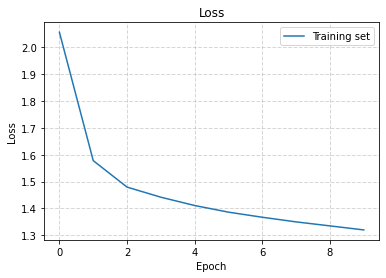

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

In [ ]:
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [ ]:
# num_generate
# - number of words to generate in sentence.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, input_indices, num_generate = max_len, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = tf.expand_dims(input_indices, axis = 0)

    # Empty string to store our results.
    data_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        data_generated.append(predicted_id)

    return (''.join(tokenizer.sequences_to_texts(np.expand_dims(np.array(data_generated), axis = 0))))

# not_words = df['Tweet'][df['is_spam'].isin([0])]
# for idx, row in enumerate(not_words):
for input_example, target_example in dataset_not.take(1):
  print(generate_text(model, input_indices = input_example))

cleveland tax cleveland topnews maga realdonaldtrump gt cleveland cleveland tax russia nfl maga trumps cleveland cops rights gt tcot breaking korea tax russia san san gt park nfl trumps nfl
